# Spotify sentiment analysis

## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import contractions
from textblob import TextBlob
import regex as re
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import seaborn as sns
from nltk.classify.scikitlearn import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import svm

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data ingestion

In [2]:
#loading the dataset into the dataframe
df = pd.read_csv('reviews.csv')[:1000]# first 1000 records only
df.head()

Time_submitted                                             Review  \
0  2022-07-09 15:00:00  Great music service, the audio is high quality...   
1  2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2  2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3  2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4  2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   

   Rating  Total_thumbsup Reply  
0       5               2   NaN  
1       5               1   NaN  
2       4               0   NaN  
3       1               1   NaN  
4       1               1   NaN

In [3]:
#Pre-processing
df.columns

Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')

In [4]:
#Getting infromation about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  1000 non-null   object
 1   Review          1000 non-null   object
 2   Rating          1000 non-null   int64 
 3   Total_thumbsup  1000 non-null   int64 
 4   Reply           2 non-null      object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [5]:
#Looking for null values
df.isnull().sum()

Time_submitted      0
Review              0
Rating              0
Total_thumbsup      0
Reply             998
dtype: int64

In [6]:
#Showing the firt 5 and last 5 rows in the target column
df['Review']

0      Great music service, the audio is high quality...
1      Please ignore previous negative rating. This a...
2      This pop-up "Get the best Spotify experience o...
3        Really buggy and terrible to use as of recently
4      Dear Spotify why do I get songs that I didn't ...
                             ...                        
995    Trash podcast player. Crashed constantly mid p...
996    Good probably but like without paying we can't...
997    Nice app! It will be great if it have a korean...
998    Been using it for years, it's always been bugg...
999                            Good experience for music
Name: Review, Length: 1000, dtype: object

In [7]:
#dropping colums that are not needed
df = df.drop(['Reply','Time_submitted'], axis = 1)

In [8]:
#Dropping duplicate values
df = df.drop_duplicates()
df = df.reset_index()

In [9]:
#Converting the reviews to a string
df['length'] = df['Review'].str.len()

In [10]:
df.length.describe()

count    1000.000000
mean      148.927000
std       123.756419
min        12.000000
25%        56.000000
50%       109.000000
75%       202.250000
max       500.000000
Name: length, dtype: float64

In [11]:
#total number of up votes
df.Total_thumbsup.describe()

count    1000.000000
mean        2.240000
std        23.600368
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       592.000000
Name: Total_thumbsup, dtype: float64

In [12]:
for i in range(len(df)):
    if df['Rating'][i] > 3:
        df['Rating'][i] = 'Good'
    elif df['Rating'][i] < 3:
        df['Rating'][i] = 'Bad'
    else:
        df['Rating'][i] = 'Neutral'

## Explaratory data analysis


In [13]:
#Correlation output of the dataset
m = df.corr()
print(m)

                   index  Total_thumbsup    length
index           1.000000       -0.008097  0.000597
Total_thumbsup -0.008097        1.000000  0.192388
length          0.000597        0.192388  1.000000


In [14]:
#representation of customer sentiment in a pie chart
colors = ['red', 'blue', 'green',]
fig = px.pie(df, values='Total_thumbsup', names='Rating', color_discrete_sequence=colors, title = 'Rating distribution pie chart')
fig.show()

In [16]:
#Boxplot to show outliers
fig = px.box(df,x = 'Rating', y = 'length')
fig.show()

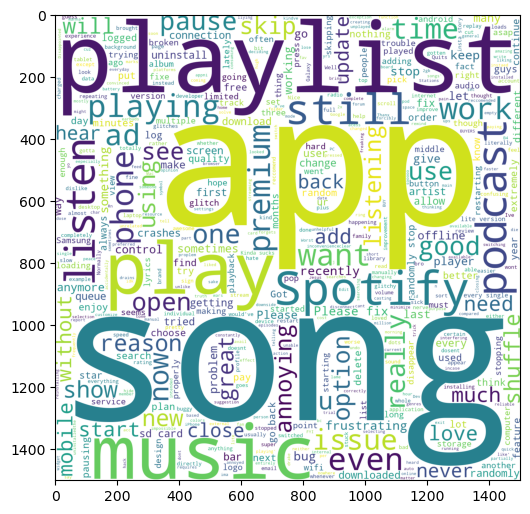

In [17]:
#visualization of neutral words
neutral = df[df['Rating'] == 'Neutral']['Review']
wc = WordCloud(width = 1500, height = 1500, background_color = 'white',max_words = 500).generate(' '.join(neutral))
plt.figure(figsize = (6,8))
plt.imshow(wc)
plt.show()

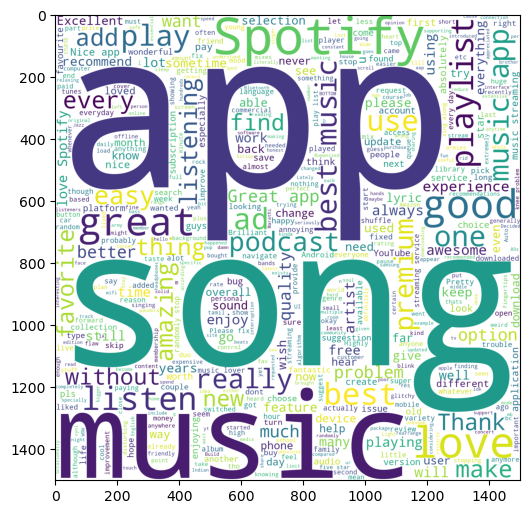

In [18]:
#visualization of positive words
good = df[df['Rating'] == 'Good']['Review']
wc = WordCloud(width = 1500, height = 1500, background_color = 'white',max_words = 500).generate(' '.join(good))
plt.figure(figsize = (6,8))
plt.imshow(wc)
plt.show()

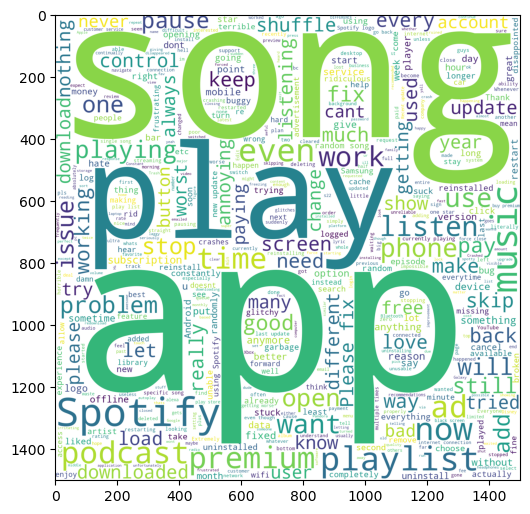

In [19]:
#visualization of negative words
bad = df[df['Rating'] == 'Bad']['Review']
wc = WordCloud(width = 1500, height = 1500, background_color = 'white',max_words = 500).generate(' '.join(bad))
plt.figure(figsize = (6,8))
plt.imshow(wc)
plt.show()

Text(0.5, 1.0, 'Thumbs ups recieved for each rating')

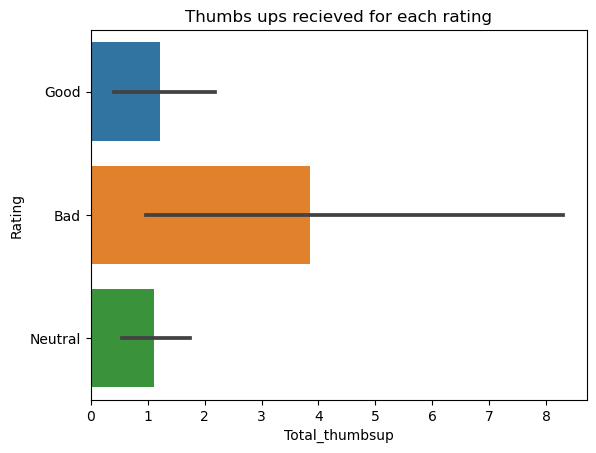

In [20]:
#representation of thumbs ups recieved for every rating
ax = sns.barplot(data = df, y = 'Rating', x = 'Total_thumbsup')
ax.set_title('Thumbs ups recieved for each rating')

In [23]:
#display of reviews in random 4 locations
for i in [0,50,100,500]:
    sent = df['Review'].values[i]
    print(sent)
    print('=' *100)

Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.
Podcasts becoming a nightmare. Trying to get rid of podcasts on this app is ridiculous. Stupid things are all over the home page. You can click not interested till you're blue in the face and I'll just keep throwing up more spam casts.
I love listening to music (I use it as a coping mechanism), so I love Spotify so much too. But, about 3 days ago (?), my Spotify wouldn't load, it would just stay on the spotify logo screen thing. Tried installing it and uninstalling it for 5 times, restarted my phone 2 times, cleared the cache/data for about 8 times, and I still can't open it (also waited for an hour for it to load).
I've been using Spotify since I first started using a phone. I can bear with the ads and everything but for some reason recently the music would just stop when I went to other apps and I'd have to start the song from the beginning again. It happened a couple time

In [24]:
#Preprocessing of reviews text
#tqdm library used to show progress of for loops
for i in tqdm(range(len(df))):
    df['Review'][i] = re.sub('\n', ' ', df['Review'][i])
    df['Review'][i] = re.sub('_','',df['Review'][i])
    df['Review'][i] = re.sub(r'\d+', '', df['Review'][i])
    df['Review'][i] = re.sub("[\(\[].*?[\)\]]", "", df['Review'][i])
    df['Review'][i] = re.sub("[()]",'', df['Review'][i])
    df['Review'][i] = df['Review'][i].lower()
    df['Review'][i] = contractions.fix(df['Review'][i])
    df['Review'][i] = re.sub(r'[^\w\s]', '', df['Review'][i])
    df['Review'][i] = re.sub(" +", ' ', df['Review'][i])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
# removing stopwords and lemmatizing
stop = set(stopwords.words('english'))
lem = WordNetLemmatizer()
for i in tqdm(range(len(df))):
    t = ''
    for word in df['Review'][i].split():
        word = str(word)
        if len(word)>2:
            if word not in stop:
                t += lem.lemmatize(word) + ' '
    df['Review'][i] = t.strip()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
#Printing those very not so random anymore reviews
for i in [0,50,100,500]:
    sent = df['Review'].values[i]
    print(sent)
    print('=' *100)

great music service audio high quality app easy use also quick friendly support
podcasts becoming nightmare trying get rid podcasts app ridiculous stupid thing home page click interested till blue face keep throwing spam cast
love listening music love spotify much day ago spotify would load would stay spotify logo screen thing tried installing uninstalling time restarted phone time cleared cachedata time still cannot open
using spotify since first started using phone bear ad everything reason recently music would stop went apps would start song beginning happened couple time thought okay happening much recently really getting nerve


In [27]:
#Building a test/train split
x = df['Review']
y = df['Rating']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 42)

In [28]:
#Label Encoding the target variable
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [30]:
#bag of words
count_vect = CountVectorizer()
count_vect.fit(x_train)
print(f'Some Feature Names: ', count_vect.get_feature_names_out()[:15])
print('=' * 50)

x_train_count = count_vect.transform(x_train)
x_test_count = count_vect.transform(x_test)
print(f'The number of unique words in test set: {x_test_count.get_shape()[1]}')

Some Feature Names:  ['aaa' 'aap' 'abd' 'ability' 'able' 'abruptly' 'absence' 'absent'
 'absolute' 'absolutely' 'absolutly' 'acc' 'accept' 'access' 'accessible']
The number of unique words in test set: 1918


In [32]:
#TFIDF along with bigrams
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10)
tf_idf_vect.fit(x_train)
print(f'Some Feature names: {tf_idf_vect.get_feature_names_out()[:15]}')
print('='*50)

x_train_tfidf = tf_idf_vect.transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(f'The number of unique words: {x_test_tfidf.get_shape()[1]}')

Some Feature names: ['able' 'absolutely' 'account' 'actually' 'ad' 'add' 'already' 'also'
 'always' 'amazing' 'android' 'annoying' 'another' 'anymore' 'anything']
The number of unique words: 226


## Classification

In [34]:
#Random Forest - BOW
rf1 = RandomForestClassifier()
rf1.fit(x_train_count, y_train)
rf1_cv = rf1.score(x_test_count, y_test)
print(f'Accuray for Random Forest classifiers on count vectors: {rf1_cv}')

Accuray for Random Forest classifiers on count vectors: 0.736


In [35]:
#Random Forest-  term frequency–inverse document frequency
rf2 = RandomForestClassifier()
rf2.fit(x_train_tfidf, y_train)
rf2_cv = rf2.score(x_test_tfidf, y_test)
print(f'Accuray for Random Forest Classifier on tfidf vectors is: {rf2_cv}')

Accuray for Random Forest Classifier on tfidf vectors is: 0.708


In [36]:
#Multinomial Naive Bayes - Bag of words
nb1 = MultinomialNB()
nb1.fit(x_train_count, y_train)
nb1_cv = nb1.score(x_test_count, y_test)
print(f'Multinomial Naive Bayes Classifier on Count Vectors: {nb1_cv}') 

Multinomial Naive Bayes Classifier on Count Vectors: 0.772


In [37]:
#Multinomial Naive Bayes - term frequency–inverse document frequency
nb2 = MultinomialNB()
nb2.fit(x_train_tfidf, y_train)
nb2_cv = nb2.score(x_test_tfidf, y_test)
print(f"Multinomial Naive Bayes Classifier on TFIDF Vectors: {nb2_cv}")

Multinomial Naive Bayes Classifier on TFIDF Vectors: 0.74


In [38]:
#MODEL RESULTS
model = {'Model':['Random Forest Classifier - BOW', 
                  'Random Forest Classifier - TFIDF', 
                  'Multinomial NB Classifier - BOW',
                  'Multinomial NB Classifier - TFIDF'],
         'Score':[rf1_cv, rf2_cv, nb1_cv, nb2_cv]
         }
model_df = pd.DataFrame(model)
model_df

Model  Score
0     Random Forest Classifier - BOW  0.736
1   Random Forest Classifier - TFIDF  0.708
2    Multinomial NB Classifier - BOW  0.772
3  Multinomial NB Classifier - TFIDF  0.740

In [42]:
#MAKING PREDICTIONS USING TRAINED MODEL
queries = ['works well sometimes', 'UI is bad, very slow', 'Amazing application']
pred = nb2.predict(tf_idf_vect.transform(queries))
pred_transformed = le.inverse_transform(pred).tolist()
result = pd.DataFrame({'Reviews':queries, 
                       'Outcome': pred_transformed})
result

Reviews Outcome
0  works well sometimes    Good
1  UI is bad, very slow     Bad
2   Amazing application    Good